In [1]:
import requests

# Base URL for the BC Data Catalogue API
BASE_URL = "https://catalogue.data.gov.bc.ca/api/3/action/"

# Dataset ID or name (for example, "labour-market-outlook" - adjust as needed)
DATASET_ID = "labour-market-outlook"

def list_dataset_resources(dataset_id):
    """
    Function to list resources for a specific dataset in the BC Data Catalogue.

    Args:
    dataset_id (str): The ID or name of the dataset.

    Returns:
    None
    """
    # Construct the URL for the dataset's details
    url = f"{BASE_URL}package_show"
    params = {"id": dataset_id}

    try:
        # Make the GET request to retrieve dataset details
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an error for bad responses

        # Parse the JSON response
        data = response.json()

        # Check if the response was successful and contains the dataset
        if data.get("success"):
            resources = data["result"]["resources"]
            print(f"Resources for dataset '{dataset_id}':\n")
            for resource in resources:
                print(f"Resource Name: {resource['name']}")
                print(f"Resource Format: {resource['format']}")
                print(f"Resource URL: {resource['url']}\n")
        else:
            print("Failed to retrieve dataset details.")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

# Call the function to list resources
list_dataset_resources(DATASET_ID)


Resources for dataset 'labour-market-outlook':

Resource Name: Employment by Ind and Occ for BC and Regions
Resource Format: csv
Resource URL: https://catalogue.data.gov.bc.ca/dataset/f9566991-eb97-49a9-a587-5f0725024985/resource/aa195dc1-f3e8-413a-b38c-24af95a3276e/download/employment-by-ind-and-occ-for-bc-and-regions.xlsx

Resource Name: Employment by Industry and Occupation for BC
Resource Format: xlsx
Resource URL: https://catalogue.data.gov.bc.ca/dataset/f9566991-eb97-49a9-a587-5f0725024985/resource/22fbd2a4-ab98-45e1-bdd9-cb4a0aebfb5b/download/employment-by-industry-and-occupation-for-bc.xlsx

Resource Name: Employment by Industry for BC and Regions
Resource Format: xlsx
Resource URL: https://catalogue.data.gov.bc.ca/dataset/f9566991-eb97-49a9-a587-5f0725024985/resource/1a3be0bc-0aa9-4014-a989-c939a70e0145/download/employment-by-industry-for-bc-and-regions.xlsx

Resource Name: Employment by Occupation for BC and Regions
Resource Format: xlsx
Resource URL: https://catalogue.data.g

In [11]:
import requests
import pandas as pd

# Define the base API URLs
package_search_url = "https://catalogue.data.gov.bc.ca/api/3/action/package_search"
resource_show_url = "https://catalogue.data.gov.bc.ca/api/3/action/resource_show"

def get_dataset_id_by_name(name):
    """
    Get the dataset ID by searching for a dataset name.
    """
    response = requests.get(package_search_url, params={"q": name})
    if response.status_code == 200:
        results = response.json().get("result", {}).get("results", [])
        if results:
            # Assuming the first match is the target dataset
            return results[0]["id"]
        else:
            print(f"No dataset found with name: {name}")
    else:
        print(f"Error fetching dataset: {response.status_code}")
    return None

def get_resource_id(dataset_id, resource_name=None):
    """
    Get the resource ID for a specific dataset based on the resource name.
    """
    response = requests.get(f"https://catalogue.data.gov.bc.ca/api/3/action/package_show?id={dataset_id}")
    if response.status_code == 200:
        resources = response.json().get("result", {}).get("resources", [])
        for resource in resources:
            if resource["name"] == resource_name:
                return resource["id"]
        print("Resource not found with the specified name.")
    else:
        print(f"Error fetching resources for dataset {dataset_id}: {response.status_code}")
    return None

def load_resource_into_dataframe(resource_id):
    """
    Load the specified resource into a DataFrame, handling different file formats.
    """
    response = requests.get(resource_show_url, params={"id": resource_id})
    if response.status_code == 200:
        resource_data = response.json().get("result", {})
        if "url" in resource_data and "format" in resource_data:
            file_url = resource_data["url"]
            file_format = resource_data["format"].lower()
            
            try:
                # Load data based on the file format
                if file_format == "csv":
                    return pd.read_csv(file_url, encoding='ISO-8859-1', on_bad_lines="skip")
                elif file_format == "xlsx" or file_format == "xls":
                    return pd.read_excel(file_url)
                elif file_format == "zip":
                    # If the data is a ZIP file, download and extract it
                    zip_response = requests.get(file_url)
                    with open("temp.zip", "wb") as f:
                        f.write(zip_response.content)
                    # Extract and load CSV from ZIP if known structure
                    import zipfile
                    with zipfile.ZipFile("temp.zip", "r") as zip_ref:
                        zip_ref.extractall("temp_data")
                        # Assuming there's a single CSV file in the ZIP
                        for filename in zip_ref.namelist():
                            if filename.endswith(".csv"):
                                return pd.read_csv(f"temp_data/{filename}", encoding='ISO-8859-1', on_bad_lines="skip")
                else:
                    print(f"Unsupported file format: {file_format}")
            except Exception as e:
                print(f"Error loading data: {e}")
        else:
            print("No data URL or format found in resource.")
    else:
        print(f"Error fetching resource data: {response.status_code}")
    return None

# Example usage
dataset_name = "labour-market-outlook"  # Adjust this if necessary
resource_name = "Job Openings by NOC and Skill Cluster"  # Targeted resource name

# Step 1: Get the dataset ID
dataset_id = get_dataset_id_by_name(dataset_name)
if dataset_id:
    # Step 2: Get the resource ID within the dataset
    resource_id = get_resource_id(dataset_id, resource_name=resource_name)
    if resource_id:
        # Step 3: Load the resource into a DataFrame
        df = load_resource_into_dataframe(resource_id)
        if df is not None:
            print("Data loaded successfully into DataFrame.")
            print(df.head())  # Display the first few rows for inspection
        else:
            print("Failed to load data into DataFrame.")


Data loaded successfully into DataFrame.
      NOC                                        Description  \
0  #10010                                 Financial managers   
1  #10011                           Human resources managers   
2  #10012                                Purchasing managers   
3  #10019             Other administrative services managers   
4  #10020  Insurance, real estate and financial brokerage...   

  Occ Group: Skills Cluster  LMO Job Openings 2023-2033  
0  Sales and administration                     3513.09  
1         People management                     3372.10  
2         People management                     1743.91  
3  Sales and administration                     3295.69  
4  Sales and administration                     3189.88  


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NOC                         501 non-null    object 
 1   Description                 501 non-null    object 
 2   Occ Group: Skills Cluster   501 non-null    object 
 3   LMO Job Openings 2023-2033  501 non-null    float64
dtypes: float64(1), object(3)
memory usage: 15.8+ KB


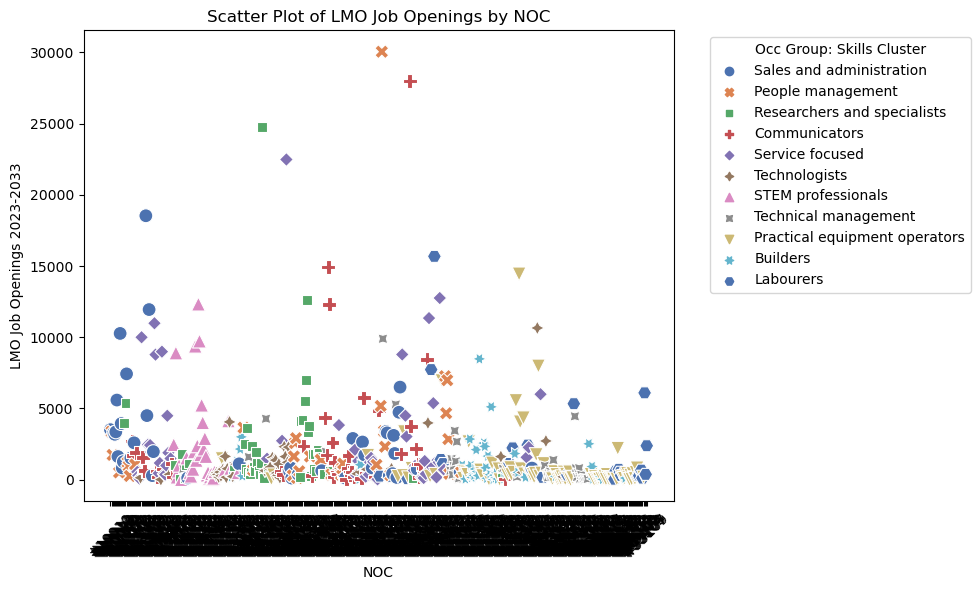

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'LMO Job Openings 2023-2033' to numeric (in case it's not)
df['LMO Job Openings 2023-2033'] = pd.to_numeric(df['LMO Job Openings 2023-2033'], errors='coerce')

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=df.index, y='LMO Job Openings 2023-2033', 
                hue='Occ Group: Skills Cluster', palette='deep', style='Occ Group: Skills Cluster', s=100)

# Set labels and title
plt.xticks(ticks=df.index, labels=df['NOC'], rotation=45)  # Set NOC as x-tick labels
plt.xlabel('NOC')
plt.ylabel('LMO Job Openings 2023-2033')
plt.title('Scatter Plot of LMO Job Openings by NOC')
plt.legend(title='Occ Group: Skills Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
